<a href="https://colab.research.google.com/github/IasyaSholihin/Project_AmikomS2/blob/main/Tugas_AI/Tuga_VGG16_%26_CNN_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

base_dir = '/content/drive/My Drive/Data_Uang'
!ls "/content/drive/My Drive/Data_Uang"

Mounted at /content/drive
bahan


In [2]:
# Tentukan nama direktori untuk latihan dan validasi
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Buat direktori latihan dan validasi beserta sub-direktorinya (seratus dan limapuluh)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

train_seratus = os.path.join(train_dir, 'seratus')
train_limapuluh = os.path.join(train_dir, 'limapuluh')
validation_seratus = os.path.join(validation_dir, 'seratus')
validation_limapuluh = os.path.join(validation_dir, 'limapuluh')

os.makedirs(train_seratus, exist_ok=True)
os.makedirs(train_limapuluh, exist_ok=True)
os.makedirs(validation_seratus, exist_ok=True)
os.makedirs(validation_limapuluh, exist_ok=True)

# Cek apakah direktori telah berhasil dibuat
print("Direktori latihan dan validasi telah dibuat:")
print("Train Directory:", train_dir)
print("Validation Directory:", validation_dir)

Direktori latihan dan validasi telah dibuat:
Train Directory: /content/drive/My Drive/Data_Uang/train
Validation Directory: /content/drive/My Drive/Data_Uang/validation


In [3]:
import random
from shutil import copyfile
import shutil

# Mendefinisikan path ke folder 'Data_Uang'
data_uang_dir = base_dir   # Ganti dengan path yang sesuai

# Memeriksa apakah folder 'Data_Uang' ada
if not os.path.exists(data_uang_dir):
    print("Folder 'Data_Uang' tidak ditemukan.")
    exit()

# Mendefinisikan path untuk folder 'bahan'
bahan_dir = os.path.join(data_uang_dir, 'bahan')

# Memeriksa apakah folder 'bahan' ada di dalam folder 'Data_Uang'
if not os.path.exists(bahan_dir):
    print("Folder 'bahan' tidak ditemukan di dalam folder 'Data_Uang'.")
    exit()

# Mendefinisikan path untuk folder 'seratus' dan 'limapuluh' di dalam folder 'bahan'
seratus_dir = os.path.join(bahan_dir, 'seratus')
limapuluh_dir = os.path.join(bahan_dir, 'limapuluh')

# Memeriksa apakah folder 'seratus' dan 'limapuluh' ada di dalam folder 'bahan'
if not os.path.exists(seratus_dir) or not os.path.exists(limapuluh_dir):
    print("Folder 'seratus' atau 'limapuluh' tidak ditemukan di dalam folder 'bahan'.")
    exit()

def train_val_split(source, train, val, train_ratio):
    # Membuat direktori jika tidak ada
    if not os.path.exists(train):
        os.makedirs(train)
    if not os.path.exists(val):
        os.makedirs(val)

    total_size = len(os.listdir(source))
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    randomized = random.sample(os.listdir(source), total_size)
    train_files = randomized[0:train_size]
    val_files = randomized[train_size:total_size]

    for i in train_files:
        i_file = os.path.join(source, i)
        destination = os.path.join(train, i)
        copyfile(i_file, destination)

    for i in val_files:
        i_file = os.path.join(source, i)
        destination = os.path.join(val, i)
        copyfile(i_file, destination)

# Pembagian Traning dan Validasi
# Traning 100k
source_00 = seratus_dir
train_00 = train_seratus
val_00 = validation_seratus
train_ratio = 0.9  # Misalkan 90% data untuk training
train_val_split(source_00, train_00, val_00, train_ratio)

# Traning 50K
source_01 = limapuluh_dir
train_01 = train_limapuluh
val_01 = validation_limapuluh
train_val_split(source_01, train_01, val_01, train_ratio)

print('Jumlah All seratus :', len(os.listdir(source_00)))
print('Jumlah Train seratus :', len(os.listdir(train_seratus)))
print('Jumlah Val seratus :', len(os.listdir(validation_seratus)))

Jumlah All seratus : 100
Jumlah Train seratus : 90
Jumlah Val seratus : 10


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=30,
                horizontal_flip=True,
                shear_range=0.3,
                fill_mode='nearest',
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=0.1
)

val_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=30,
                horizontal_flip=True,
                shear_range=0.3,
                fill_mode='nearest',
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=0.1
)

train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(150, 150),
      batch_size=10,
      class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
      validation_dir,
      target_size=(150, 150),
      batch_size=10,
      class_mode='categorical'
)

Found 180 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


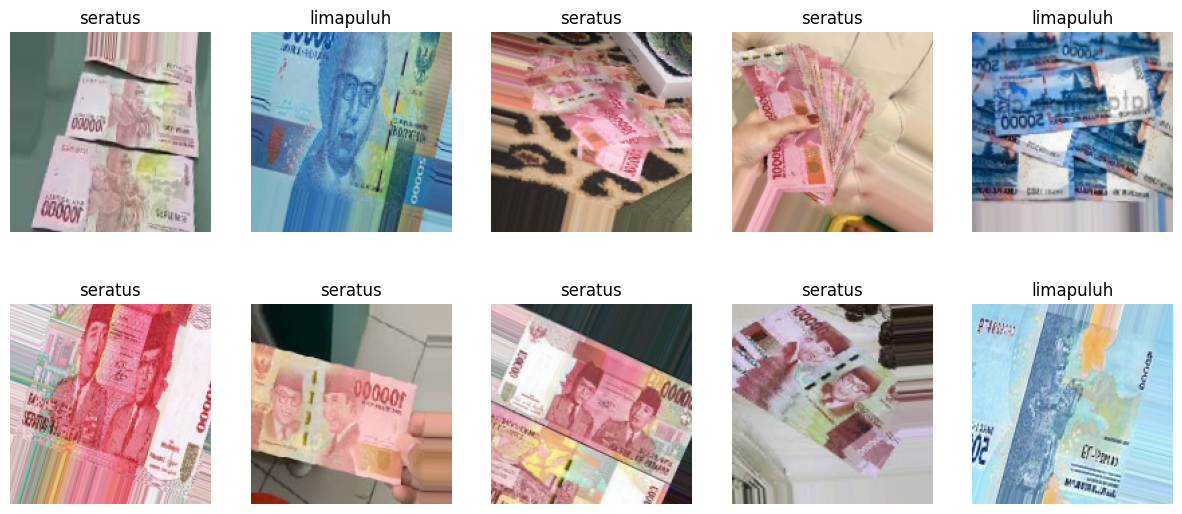

In [8]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['limapuluh', 'seratus']

plt.figure(figsize=(15, 10))
images, labels = next(train_generator)
for i in range(10):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.title(categories[np.argmax(labels[i])])
    plt.axis("off")


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Inisialisasi model VGG16 tanpa lapisan fully connected di atasnya
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Membekukan semua layer dari VGG16 agar tidak dilatih ulang
for layer in base_model.layers:
    layer.trainable = False

# Menambahkan lapisan fully connected di atas VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # Menggunakan softmax untuk klasifikasi multi-kelas

# Menggabungkan base_model dengan lapisan fully connected yang baru
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.99):
      print('\n Akurasi Mencapai 99%')
      self.model.stop_training = True

checkpoint = myCallback()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
            train_generator,
            steps_per_epoch=6,
            epochs=25,
            validation_data=val_generator,
            validation_steps=1,
            verbose=1,
            callbacks=[checkpoint]
            )


Epoch 1/25
6/6 [==============================] - 23s 3s/step - loss: 0.9790 - accuracy: 0.4833 - val_loss: 0.6819 - val_accuracy: 0.6000
Epoch 2/25
6/6 [==============================] - 22s 4s/step - loss: 0.8347 - accuracy: 0.5500 - val_loss: 0.5100 - val_accuracy: 0.8000
Epoch 3/25
6/6 [==============================] - 21s 4s/step - loss: 0.8231 - accuracy: 0.6333 - val_loss: 0.5903 - val_accuracy: 0.6000
Epoch 4/25
6/6 [==============================] - 19s 3s/step - loss: 0.8285 - accuracy: 0.6500 - val_loss: 0.4318 - val_accuracy: 0.6000
Epoch 5/25
6/6 [==============================] - 22s 4s/step - loss: 0.8685 - accuracy: 0.6500 - val_loss: 0.8702 - val_accuracy: 0.7000
Epoch 6/25
6/6 [==============================] - 23s 4s/step - loss: 0.6138 - accuracy: 0.7667 - val_loss: 0.6402 - val_accuracy: 0.8000
Epoch 7/25
6/6 [==============================] - 22s 4s/step - loss: 0.6552 - accuracy: 0.7500 - val_loss: 0.6045 - val_accuracy: 0.8000
Epoch 8/25
6/6 [==================

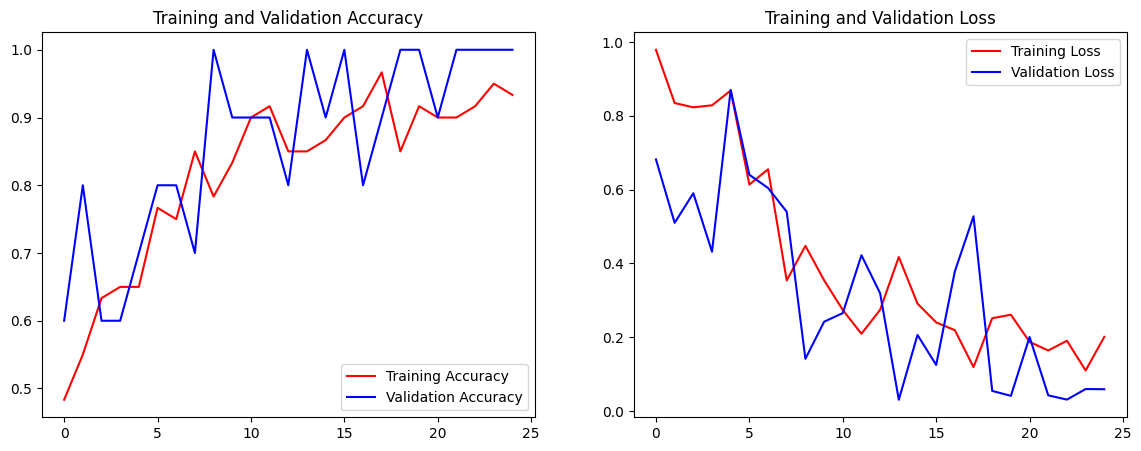

Test Loss: 0.05632776767015457
Test Accuracy: 1.0
+----+---------+----------+--------------+
|    | Model   |     Test |   Validation |
+====+=========+==========+==============+
|  0 | VGG 16  | 0.972222 |            1 |
+----+---------+----------+--------------+


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting Training and Validation Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')

plt.show()

# Evaluating Model
score1= model.evaluate(train_generator, verbose=0)
val_score1= model.evaluate(val_generator, verbose=0)
print('Test Loss:', val_score1[0])
print('Test Accuracy:', val_score1[1])

m1_accu = score1[1]
m1_accu_val =  val_score1[1]

s = pd.DataFrame({"Model":["VGG 16"],"Test":[m1_accu],"Validation":[m1_accu_val]})
tableMk=s.to_markdown(tablefmt="grid")
print(tableMk)


Saving 50.jpeg to 50.jpeg
1/1 [==============================] - 1s 866ms/step
50.jpeg
Gambar Ini limapuluh


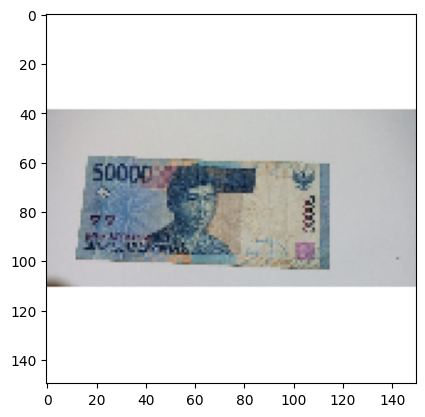

In [12]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn

    # Prediksi Gambar
    img = image.load_img(path, target_size=(150, 150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=100)

    print(fn)

    class_list = os.listdir(train_dir)

    for j in range(len(classes[0])):
        if classes[0][j] == 1.:
            print('Gambar Ini', class_list[j-1])
            break